In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import argparse
import os
import numpy as np
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.visualization import plot_spectogram
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , compute_fft_train_data , load_raw_data , compute_fft_train_data , trim_iq_basic_block
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
%matplotlib inline

Using TensorFlow backend.


In [3]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m train -d iq_data/CELL/anomal/CELL_SWP_18MHz_50us_10dB -w model/baseline_cepstrum".split()
namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')

In [4]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
train = namespace.mode == 'train'


atom_height = 1
fraction = 0.2
num_clusters = 1000
data_dir = namespace.data_dir

f_s = get_xhdr_sample_rate(data_dir)
test_window_time = 10e-6
cv_types = ['diag']

assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[1]
recording_name = str.split(data_dir,'/')[-1]

In [5]:
for rbw in rbw_set:
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    
    sample_rate = get_xhdr_sample_rate(data_dir)
    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate)
    freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)

iq_data too long... shortening to basic block


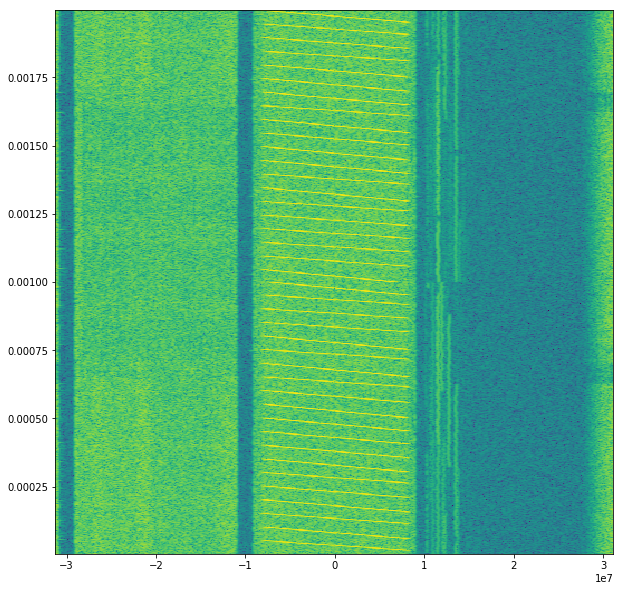

In [6]:
plot_spectogram(fft_train,freqs,time)

In [7]:
fft_train.apply(lambda x : iq2fft())

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [ ]:
def compute_frequency_spectrum(freq):
    